## Stylize Your Images In 5 Minutes

Demo developed by [Sayak Paul](https://twitter.com/RisingSayak).

Neural style transfer is one of the most interesting applications of deep learning. We've created a demo to help you recreate your images in the style of famous artists. 

![](https://storage.googleapis.com/download.tensorflow.org/models/tflite/arbitrary_style_transfer/table.png)

The image and code id adapted from [this tutorial](https://www.tensorflow.org/lite/models/style_transfer/overview). 

In [1]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from io import BytesIO
import numpy as np
import requests

In [8]:
style_image_path = "./style.png"
content_image = Image.open("./temp.png")

You can upload as many images as you would want to but we will only pick the last uploaded one. 

In [ ]:
# Load the images
# Function to load an image from a file, and add a batch dimension.
def load_img_opencv(img_path):
    img = cv.imread(img_path)
    img = np.float32(img)/255.0
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img = tf.convert_to_tensor(img)
    img = img[tf.newaxis, :]

In [9]:
# Load the images
# Function to load an image from a file, and add a batch dimension.
def load_img(path_to_img):
  img = tf.io.read_file(path_to_img)
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)
  img = img[tf.newaxis, :]

  return img

# Function to load an image from a file, and add a batch dimension.
def load_content_img(image_pixels):
    if image_pixels.shape[-1] == 4:
        image_pixels = Image.fromarray(image_pixels)
        img = image_pixels.convert('RGB')
        img = np.array(img)
        img = tf.convert_to_tensor(img)
        img = tf.image.convert_image_dtype(img, tf.float32)
        img = img[tf.newaxis, :]
        return img
    elif image_pixels.shape[-1] == 3:
        img = tf.convert_to_tensor(image_pixels)
        img = tf.image.convert_image_dtype(img, tf.float32)
        img = img[tf.newaxis, :]
        return img
    elif image_pixels.shape[-1] == 1:
        raise Error('Grayscale images not supported! Please try with RGB or RGBA images.')
    print('Exception not thrown')

# Function to pre-process by resizing an central cropping it.
def preprocess_image(image, target_dim):
  # Resize the image so that the shorter dimension becomes 256px.
  shape = tf.cast(tf.shape(image)[1:-1], tf.float32)
  short_dim = min(shape)
  scale = target_dim / short_dim
  new_shape = tf.cast(shape * scale, tf.int32)
  image = tf.image.resize(image, new_shape)

  # Central crop the image.
  image = tf.image.resize_with_crop_or_pad(image, target_dim, target_dim)

  return image

# Convert the content image from Bytes to NumPy array.
content_image = np.array(content_image)

# Load the input images.
content_image = load_content_img(content_image)
style_image = load_img(style_image_path)
print('Images loaded up!')

Images loaded up!


In [10]:
# Point to the model files
style_predict_path = 'predict.tflite'
style_transform_path = 'transfer.tflite'

Preprocessing the style and the content images...
Style image shape: (1, 256, 256, 3)
Content image shape: (1, 350, 350, 3)
Calculating style bottleneck...


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


Style Bottleneck Shape: (1, 1, 1, 100)
Stylizing image. It should not take more than three minutes...


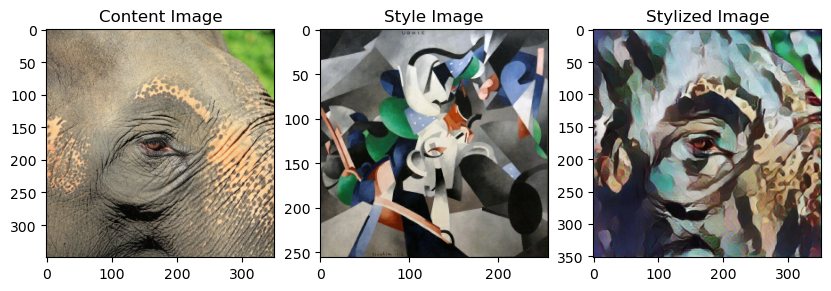

In [8]:
# Stylize image 🥁

content_blending_ratio = 0 #@param {type:"slider", min:0, max:1, step:0.1}
#@markdown You're encouraged to play with the different values of `content_blending_ratio`.

content_image_size = 350 #@param {type:"slider", min:192, max:512, step:1}

# Preprocess the input images.
preprocessed_content_image = preprocess_image(content_image, content_image_size)
preprocessed_style_image = preprocess_image(style_image, 256)

print('Preprocessing the style and the content images...')
print('Style image shape:', preprocessed_style_image.shape)
print('Content image shape:', preprocessed_content_image.shape)

def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

plt.figure(figsize=(10, 10))

plt.subplot(1, 3, 1)
imshow(preprocessed_content_image, 'Content Image')

plt.subplot(1, 3, 2)
imshow(preprocessed_style_image, 'Style Image')

# Function to run style prediction on preprocessed style image.
def run_style_predict(preprocessed_style_image):
  # Load the model.
  interpreter = tf.lite.Interpreter(model_path=style_predict_path)

  # Set model input.
  interpreter.allocate_tensors()
  input_details = interpreter.get_input_details()
  interpreter.set_tensor(input_details[0]["index"], preprocessed_style_image)

  # Calculate style bottleneck.
  interpreter.invoke()
  style_bottleneck = interpreter.tensor(
      interpreter.get_output_details()[0]["index"]
      )()

  return style_bottleneck

# Calculate style bottleneck for the preprocessed style image.
print('Calculating style bottleneck...')
style_bottleneck = run_style_predict(preprocessed_style_image)
print('Style Bottleneck Shape:', style_bottleneck.shape)
print('Stylizing image. It should not take more than three minutes...')

# Run style transform on preprocessed style image
def run_style_transform(style_bottleneck, preprocessed_content_image):
  # Load the model.
  interpreter = tf.lite.Interpreter(model_path=style_transform_path)

  # Set model input.
  input_details = interpreter.get_input_details()
  for index in range(len(input_details)):
    if input_details[index]["name"]=='content_image':
      index = input_details[index]["index"]
      interpreter.resize_tensor_input(index, [1, content_image_size, content_image_size, 3])
  interpreter.allocate_tensors()

  # Set model inputs.
  for index in range(len(input_details)):
    if input_details[index]["name"]=='Conv/BiasAdd':
      interpreter.set_tensor(input_details[index]["index"], style_bottleneck)
    elif input_details[index]["name"]=='content_image':
      interpreter.set_tensor(input_details[index]["index"], preprocessed_content_image)
  interpreter.invoke()

  # Transform content image.
  stylized_image = interpreter.tensor(
      interpreter.get_output_details()[0]["index"]
      )()

  return stylized_image

# Calculate style bottleneck of the content image.
style_bottleneck_content = run_style_predict(
    preprocess_image(content_image, 256)
)

# Blend the style bottleneck of style image and content image
style_bottleneck_blended = content_blending_ratio * style_bottleneck_content \
                           + (1 - content_blending_ratio) * style_bottleneck

# Stylize the content image using the style bottleneck.
stylized_image = run_style_transform(style_bottleneck_blended, preprocessed_content_image)

# Visualize the output.
plt.subplot(1, 3, 3)
imshow(stylized_image, 'Stylized Image')

Credit: https://github.com/sayakpaul/Adventures-in-TensorFlow-Lite/blob/master/Style_Transfer_Demo_InceptionV3_Dynamic_Shape.ipynb